<a href="https://colab.research.google.com/github/lazybuttrying/TensorFlow-Certificate/blob/main/C2/W3/ungraded_labs/C2_W3_Lab_1_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Click the button on top that says, `Open in Colab`, to run this notebook as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

# pre-trained weights 가져오기
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  


--2021-09-30 08:46:26--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 108.177.121.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   180MB/s    in 0.5s    

2021-09-30 08:46:26 (180 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False # pre-trained weights를 그대로 쓰기 위해
  
# pre_trained_model.summary()

#Transfer Learning을 보고 기존 모델을 사용하여 
#많은 레이어를 동결하여 재훈련을 방지하고 
#이미지에 맞게 훈련된 컨볼루션을 효과적으로 '기억'하는 방법을 보았습니다. 

#그런 다음 이 아래에 고유한 DNN을 추가하여 
#다른 모델의 컨볼루션을 사용하여 이미지를 다시 학습할 수 있습니다. 

last layer output shape:  (None, 7, 7, 768)


In [4]:
from tensorflow.keras.optimizers import RMSprop


# 모든 레이어에는 이름이 있으니, 마지막 레이어의 이름을 보고 싶을 때

last_layer = pre_trained_model.get_layer('mixed7') 
# mixed7은 7x7인 convolution의 출력
# 이 layer를 쓸 필요는 없으며, 다른 사람과 실헝할 때 재미로 쓰기 좋음
# 이 코드를 사용하면 inception model로부터 마지막 레이어를 잡아서 최종 출력까지 데리고 감
 
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output) 

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)    # overfitting을 해결하기 위해 
# 20%의 unit을 탈락시킴

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)   # 이진 분류이므로 unit 1개  

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [5]:
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Downloading...
From: https://drive.google.com/uc?id=1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
To: /content/cats_and_dogs_filtered.zip
68.6MB [00:00, 165MB/s]
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 57s - loss: 0.3494 - accuracy: 0.8590 - val_loss: 0.1148 - val_accuracy: 0.9560
Epoch 2/20
100/100 - 21s - loss: 0.2478 - accuracy: 0.9040 - val_loss: 0.0944 - val_accuracy: 0.9660
Epoch 3/20
100/100 - 21s - loss: 0.2040 - accuracy: 0.9265 - val_loss: 0.1034 - val_accuracy: 0.9690
Epoch 4/20
100/100 - 21s - loss: 0.2060 - accuracy: 0.9235 - val_loss: 0.1123 - val_accuracy: 0.9600
Epoch 5/20
100/100 - 21s - loss: 0.1842 - accuracy: 0.9290 - val_loss: 0.1107 - val_accuracy: 0.9570
Epoch 6/20
100/100 - 21s - loss: 0.1581 - accuracy: 0.9390 - val_loss: 0.1285 - val_accuracy: 0.9610
Epoch 7/20
100/100 - 21s - loss: 0.1713 - accuracy: 0.9400 - val_loss: 0.1202 - val_accuracy: 0.9610
Epoch 8/20
100/100 - 22s - loss: 0.1674 - accuracy: 0.9425 - val_loss: 0.1772 - val_accuracy: 0.9500
Epoch 9/20
100/100 - 21s - loss: 0.1609 - accuracy: 0.9440 - val_loss: 0.1125 - val_accuracy: 0.9650
Epoch 10/20
100/100 - 21s - loss: 0.1415 - accuracy: 0.9540 - val_loss: 0.1221 - val_accura

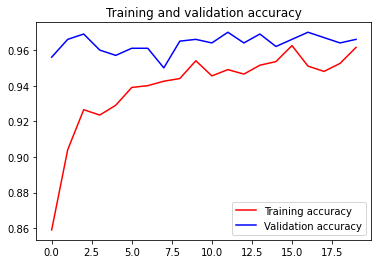

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()
# train은 90%, valid는 97%로 overfitting을 피한 좋은 상태